In [1]:
import torch

import os
import sys
sys.path.append("/home/msst/repo/Quantization/microxcaling")
sys.path.append("/home/msst/repo/Quantization")

import qlib

In [12]:
from mx import finalize_mx_specs

mx_specs = {
    #'w_elem_format': 'fp4_e2m1',
    #'w_elem_format': 'fp6_e2m3',
	#'w_elem_format': 'fp6_e3m2',
	'w_elem_format': 'fp8_e4m3',
	#'w_elem_format': 'int4',
    #'w_elem_format': 'int8',
    #'a_elem_format': 'fp6_e3m2',
    'block_size': 32,
    'bfloat': 16,
    'custom_cuda': False, #True,
    # For quantization-aware finetuning, do backward pass in FP32
    'quantize_backprop': False,
}
mx_specs = finalize_mx_specs(mx_specs)

In [13]:
model_name='Llama2-7b-hf'
#model_name='Llama-3.2-1B'

DTYPE = torch.float16
fp_model, _ = qlib.load_llama(
	model_name=model_name, 
	device_map='cpu', 
	torch_dtype=DTYPE
)

w = fp_model.get_decoder().layers[0].self_attn.q_proj.weight.data

#w = fp_model.get_decoder().layers[31].mlp.down_proj.weight.data.float()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
from mx.mx_ops import (
	_get_format_params, _reshape_to_blocks, 
	_shared_exponents, _undo_reshape_to_blocks
)


def get_shared_exps(A, mx_specs, axes):
    block_size = mx_specs['block_size']
    if mx_specs["scale_bits"] == 0:
        scale_bits = 8
    else:
        scale_bits = mx_specs["scale_bits"]
    
    axes = [axes] if type(axes) == int else axes
    axes = [x + A.ndim if x < 0 else x for x in axes]    
    shared_exp_axes = [x + 1 for x in axes] if block_size > 0 else axes
            
    A, axes, orig_shape, padded_shape = _reshape_to_blocks(
        A, axes, block_size
    )

    shared_exp = _shared_exponents(
        A, method=mx_specs['shared_exp_method'], axes=shared_exp_axes, ebits=0,
    )

    emax = _get_format_params(mx_specs['w_elem_format'])[2]
    shared_exp = shared_exp - emax
    
    scale_emax = 2**(scale_bits-1) - 1
    shared_exp[shared_exp > scale_emax] = float("NaN")
    shared_exp[shared_exp < -scale_emax] = -scale_emax
    
    return shared_exp

In [16]:
# diap_max_f = -torch.inf
# exp_min_f = torch.inf
# exp_max_f = -torch.inf

# for n, m in fp_model.named_modules():
#     if isinstance(m, torch.nn.Linear):
#         #w = fp_model.get_decoder().layers[0].self_attn.q_proj.weight
#         w = m.weight.data
#         shared_exp = get_shared_exps(w, mx_specs, axes=[-1])
        
#         exp_min = shared_exp.min().item()    
#         exp_max = shared_exp.max().item()
#         diap = exp_max - exp_min + 1

#         if diap > diap_max_f:
#             diap_max_f = diap
#         if exp_max > exp_max_f:
#             exp_max_f = exp_max
#         if exp_min < exp_min_f:
#             exp_min_f = exp_min
#         print(diap, exp_min, exp_max, n)

# print("diap_max_f:", diap_max_f, "exp_min_f", exp_min_f, "exp_max_f:", exp_max_f)

# # fp4_e2m1 diap_max_f: 10.0 exp_min_f -12.0 exp_max_f: -2.0
# # fp6_e3m2 diap_max_f: 10.0 exp_min_f -14.0 exp_max_f: -4.0
# # fp8_e4m3 diap_max_f: 10.0 exp_min_f -18.0 exp_max_f: -8.0

In [5]:
from mx.elemwise_ops import quantize_elemwise_op
from mx.mx_ops import quantize_mx_op

bf_weight = quantize_elemwise_op(
    w, mx_specs=mx_specs, round=mx_specs["round_weight"]
)

qis_weight = quantize_mx_op(
    bf_weight,
    mx_specs,
    elem_format=mx_specs['w_elem_format'],
    axes=[-1],
    round=mx_specs["round_mx_output"],
)

shared_exp = get_shared_exps(w, mx_specs, axes=[-1])

In [9]:
axes = [-1]
block_size = mx_specs['block_size']

w_, axes, orig_shape, padded_shape = _reshape_to_blocks(
        w, axes, block_size
)

qis_weight_, axes, orig_shape, padded_shape = _reshape_to_blocks(
        qis_weight, axes, block_size
)

w__ = _undo_reshape_to_blocks(w_, padded_shape, orig_shape, axes)

In [10]:
with torch.no_grad():
    scaled = qis_weight_ / 2**shared_exp
    uniq_pos = torch.unique(scaled.abs())
print(len(uniq_pos))
print(uniq_pos)

#torch.save(uniq_pos, f"/home/msst/repo/Quantization/logs/{mx_specs['w_elem_format']}_unique_positive_values.pth")

128
tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844, 1.0000, 1.0156, 1.0312, 1.0469, 1.0625, 1.0781, 1.0938, 1.1094,
        1.1250, 1.1406, 1.1562, 1.1719, 1.1875, 1.2031, 1.2188, 1.2344, 1.2500,
        1.2656, 1.2812, 1.2969, 1.3125, 1.3281, 1.3438, 1.3594, 1.3750, 1.3906,
        1.4062, 1.4219, 1.4375, 1.4531, 1.4688, 1.4844, 1.5000, 1.5156, 1.5312,
        1.5469, 1.5625, 1.5781, 1.5938, 1.6094, 1.6250, 1.6406, 1.6562, 1.6719,
        1.6875, 1.7031, 1.7188, 1.73

In [20]:
import matplotlib.pyplot as plt

def plot_hist(data, bins=32, figsize=(4, 4)):
    data_np = data.flatten().numpy()

    plt.figure(figsize=figsize)
    plt.hist(data_np, bins=bins, edgecolor='black')
    plt.grid(True, alpha=0.3)
    plt.show()


def get_positive_lowbit_codebook(base_codebook_size, values_bits, bound):
    """Generate a symmetric low-bit codebook"""
    sample_values = int(base_codebook_size * 1.5)
    scale = bound / ((2**(values_bits-1)) - 0.5)

    quantiles = torch.special.ndtr(scale * (torch.arange(2**(values_bits-1))))
    quantiles_padded = torch.tensor(list(quantiles) + [1])
    freq = (quantiles_padded[1:] - quantiles_padded[:-1]).unsqueeze(0)
    freq_2d = freq.T @ freq

    counts = (freq_2d * sample_values / freq_2d.sum())
    counts = counts.round()
    counts = counts.flatten()

    unique_values = (torch.arange(2**(values_bits-1)) + 0.5)
    unique_cb_h = unique_values.repeat(len(unique_values), 1)
    unique_cb_v = unique_cb_h.T
    unique_cb_2d = torch.stack([unique_cb_v, unique_cb_h], dim=0)

    unique_cb = unique_cb_2d.reshape(2, -1).T

    cb = []
    for i, c in enumerate(counts):
        cb += int(c) * [unique_cb[i],]
        
    cb = torch.stack(cb)
    n_to_remove = len(cb)- base_codebook_size
    torch.manual_seed(0)
    cb = cb[torch.randperm(len(cb))][n_to_remove:]

    return cb, scale


def quantlut_sym_2d(tlut, L, nbits):
    """2D quantized lookup table with sign flipping"""
    with torch.no_grad():
        lut = torch.arange(1 << L, device=tlut.device)
        lut = (lut + 1) * lut
        sflp0 = 1 - ((lut >> 15) & 1) * 2
        sflp1 = 1 - ((lut >> 13) & 1) * 2
        lut = (lut >> (16 - nbits - 1)) & ((1 << nbits) - 1)
    lut = tlut[lut] * torch.stack([sflp0, sflp1]).T
    return lut

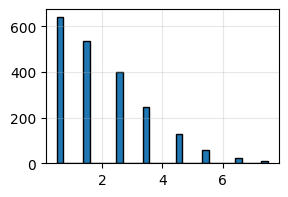

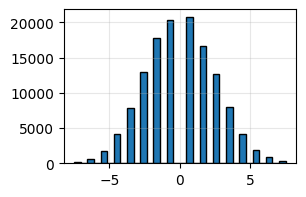

In [21]:
tlut_bits = 10
values_bits = 4
bound = 3
L = 16

tlut, scale = get_positive_lowbit_codebook(2**tlut_bits, values_bits=values_bits, bound=bound)
lut = quantlut_sym_2d(tlut, L, tlut_bits)

plot_hist(tlut, bins=32, figsize=(3, 2))
plot_hist(lut, bins=32, figsize=(3, 2))

In [22]:
def get_gaussian_distributed_positive_2d_codebook(base_codebook_size, base_values):
    """Generate a symmetric low-bit codebook"""
    sample_values = int(base_codebook_size * 1.5)
    gaussian_bound = 2 #2 #2.5

    # quantiles = 1 - torch.special.ndtr(base_values / base_values.max() * gaussian_bound)
    # print(base_values / base_values.max() * gaussian_bound)
    # print(quantiles)

    normed_base_values = base_values / base_values.max() * gaussian_bound
    quantiles = (1 / 2 ** 0.5) * torch.exp(- normed_base_values ** 2)

    freq = (quantiles / quantiles.sum()).unsqueeze(0)

    print("freq:", freq)

    if base_values.abs().min() == 0.0:
        freq[:, 0] /= 2
    
    freq_2d = freq.T @ freq

    counts = (freq_2d * sample_values / freq_2d.sum())
    counts = counts.round()
    counts = counts.flatten()

    unique_values = base_values
    unique_cb_h = unique_values.repeat(len(unique_values), 1)
    unique_cb_v = unique_cb_h.T
    unique_cb_2d = torch.stack([unique_cb_v, unique_cb_h], dim=0)

    unique_cb = unique_cb_2d.reshape(2, -1).T

    cb = []
    for i, c in enumerate(counts):
        cb += int(c) * [unique_cb[i],]
        
    cb = torch.stack(cb)
    n_to_remove = len(cb)- base_codebook_size
    torch.manual_seed(0)
    cb = cb[torch.randperm(len(cb))][n_to_remove:]

    return cb

In [66]:
def get_gaussian_distributed_positive_2d_codebook(base_codebook_size, base_values, gaussian_bound):
    """Generate a symmetric low-bit codebook"""

    base_values = base_values.float()
    sample_values = int(base_codebook_size * 1.5)

    normed_base_values = base_values / base_values.max() * gaussian_bound
    averages_for_normed_base_values = (normed_base_values[1:] + normed_base_values[:-1]) / 2
    quantiles = torch.special.ndtr(averages_for_normed_base_values)
    quantiles_padded = torch.tensor([0.5] + list(quantiles) + [1])
    freq = (quantiles_padded[1:] - quantiles_padded[:-1]).unsqueeze(0)

    freq_2d = freq.T @ freq

    counts = (freq_2d * sample_values / freq_2d.sum())
    counts = counts.round()
    counts = counts.flatten()

    unique_values = base_values
    unique_cb_h = unique_values.repeat(len(unique_values), 1)
    unique_cb_v = unique_cb_h.T
    unique_cb_2d = torch.stack([unique_cb_v, unique_cb_h], dim=0)

    unique_cb = unique_cb_2d.reshape(2, -1).T

    cb = []
    for i, c in enumerate(counts):
        cb += int(c) * [unique_cb[i],]
        
    cb = torch.stack(cb)
    n_to_remove = len(cb)- base_codebook_size
    torch.manual_seed(0)
    cb = cb[torch.randperm(len(cb))][n_to_remove:]

    return cb

tlut.abs().max(): tensor(7.5000)
tlut.abs().min(): tensor(0.)


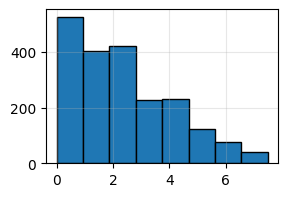

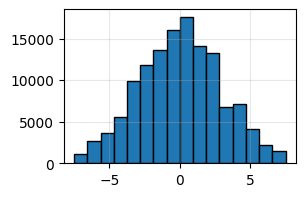

In [74]:
#mx_format = 'fp4_e2m1'
mx_format = 'fp6_e2m3'
#mx_format = 'fp8_e4m3'

unique_positive_values = torch.load(
	f'/home/msst/repo/Quantization/logs/{mx_format}_unique_positive_values.pth', 
	weights_only=True
)

tlut_bits = 10
gaussian_bound = 2.5 #2.75
L = 16

tlut = get_gaussian_distributed_positive_2d_codebook(
	base_codebook_size=2**tlut_bits, 
	base_values=unique_positive_values,
	gaussian_bound=gaussian_bound)
lut = quantlut_sym_2d(tlut, L, tlut_bits)


print("tlut.abs().max():", tlut.abs().max())
print("tlut.abs().min():", tlut.abs().min())


bins = 16 #64 #32
plot_hist(tlut, bins=bins//2, figsize=(3, 2))
plot_hist(lut, bins=bins, figsize=(3, 2))

In [25]:
lut.abs().min()

tensor(0.)